## Theories
- Law of one price: if P($port_a$ = $port_b$ at time T)=1, then, $port_a$ = $port_b$ at time time 0


- Take European call option as an example
- $port_b$ would be holding the call option, $port_a$ would be holding stock and cash in bank receiving risk-free interests
- Assume exercising call option at time T, need K. So capital required at time 0 is $K*e^{-rt}$
- assume port_a have stock = $S_0$, and capital = $b_0$= 1 at the beginning, port_b has derivatives $C_0$ at the beginning
- assume unit of stock and capital in port_a is $\alpha$, and $\beta$ respectively
- assume u is the up factor, d is the down factor, q is the risk-neutral probability
- Define port_a at time T if stock price goes up: $S_0(u)$, $b_0(e^{rt})$, port_b will be $C_u$
- Define port_a at time T if stock price goes down: $S_0(d)$, $b_0(e^{rt})$, port_b will be $C_d$


- Derive formula: $C_0$ = $\alpha$($b_0$) + $\beta$($S_0$)
    - pay attention q = ($S_0(e^{rt})-S_d$)/($S_u - S_d$), which is a risk neutral probability, not a physical probability
    - can simplify it as ($S_0(e^{rt})-S_0(d)$)/($S_0(u) - S_0(d)$)
    - net off $S_0$
    - $q = (e^{rt}-d)/(u-d)$
    - explanation on why this is the risk neutral probability we are looking for, https://www.youtube.com/watch?v=G8eFo4yIdrY
- Therefore, can derive formula: $C_0$ = $e^{-rt}$($C_u$(q) + $C_d$(1-q))


- extend single period condition to multiple periods condition
- reference of sample questions: https://analystprep.com/study-notes/frm/part-1/valuation-and-risk-management/binomial-trees/

### Implementation of the binomial pricing model
- treat binomial tree as a network with nodes (i,j) with i representing the time steps and j representing the number of ordered price outcome, lowest, or bottom of tree, to highest.
- use $S_{i,j}$ to represent the position of portfolio value in different conditions
- define $S_{i,j}$ as $S_0$($u^j$)($d^{(i-j)}$)
- $C_{i,j}$  represents contract price at each node (i,j). Where $C_{N,j}$ represents final payoff function that we can define.
- for a European Call, $C_{N,j}$=max($S_{N,j}$−K,0)


- take time at $T_3$ as an example:
    - if Time step = N, then we will have N+1 columes of values, the i = j =3, (0,1,2,3), got 4 columns of values
    - so if we want to move the pointer on $S_{3,0}$ to $S_{3,1}$, we can time it with $(u/d)$. Same logic, if we want to move the pointer from the latter one to the former one, time the latter one with $(d/u)$. It is a zig-zag move in a binomial tree structure
    - $S_{3,0}$ will divide by d first, back to $S_{2,0}$
    - then $S_{2,0}$ will time with u to go to $S_{3,1}$


- Observed the binomial tree model's structure, we can have two useful findings:
    - once we have the values at $T_N$, we can calculate the values at $T_{N-1}$ by applying the pricing formula we derived
    - we can use numpy array to store the values at each column to conduct array operation rather than generating single value by for-loop function (it is conducting a single period pricing many times, however we can do it all at once). Array multiplication is much faster when complexity or N is large


- then, using a generic timing wrapper function to judge the time performance of using numpy arrays over for loops to iterate over j nodes in each time step i.

In [1]:
import numpy as np
from functools import wraps
from time import time

In [2]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

#### 1.Initialise parameters

In [3]:
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # ensure recombining tree
opttype = 'C' # Option Type 'C' or 'P'

#### 2. Binomial Tree Slow
- For the binomial tree slow, use for loops to iterate through nodes j at each time step i.

In [4]:
@timing
def binomial_tree_slow(K,T,S0,r,N,u,d,opttype='C'):
    #precompute constants
    dt = T/N
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1) # set up an array of 0 first, then update the values
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d #zig-zag move
    
    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        C[j] = max(0, S[j]-K)
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i): # why to i? since if we have 3 time steps, we will have 4 cols of values, we will start with finding the value of C along the N-1 cols
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
    
    return C[0]
binomial_tree_slow(K,T,S0,r,N,u,d,opttype='C')

func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0001 sec


10.145735799928817

In [5]:
S = np.zeros(N+1)
S

array([0., 0., 0., 0.])

In [6]:
list(np.arange(N,0,-1))

[3, 2, 1]

In [7]:
list(range(0,3))

[0, 1, 2]

#### 2. Binomial Tree Fast
- vectorise out code using numpy arrays instead of for loops through j nodes

In [8]:
@timing
def binomial_tree_fast(K,T,S0,r,N,u,d,opttype='C'):
    #precompute constants
    dt = T/N
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1)) # from bottom to top d^(3,2,1,0),u^(0,1,2,3)
    
    # initialise option values at maturity
    C = np.maximum( C - K , np.zeros(N+1) )
        
    # step backwards through tree (getting the array of values of the previous T step)
    for i in np.arange(N,0,-1):
        C = disc * ( q * C[1:i+1] + (1-q) * C[0:i] ) # no j to help us to define the locaiton, use iloc to replace it
        # the point is looking at the graph, we can see C[0,1,2] will time with (1-q) once at T3, when we cal the values at T2
        # same, we can see C[1,2,3] will time with (q) once at T3
        # for np format, right close, so [0:4] is [0,1,2,3]
    
    return C[0]
binomial_tree_fast(K,T,S0,r,N,u,d,opttype='C')

func:'binomial_tree_fast' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0001 sec


10.145735799928826

In [9]:
dt = T/N
q = (np.exp(r*dt) - d) / (u-d)
disc = np.exp(-r*dt)
C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1))
C

array([ 75.13148009,  90.90909091, 110.        , 133.1       ])

In [10]:
C = np.maximum( C - K , np.zeros(N+1) )
C

array([ 0. ,  0. , 10. , 33.1])

### Binomial Tree Slow vs Fast
- compare runtimes for slow vs fast. Ignore option price changes as this is impacted with changing the time steps and keeping the u and d factors the same.

In [11]:
for N in [3,50, 100, 1000, 5000]:
    binomial_tree_slow(K,T,S0,r,N,u,d,opttype='C')
    binomial_tree_fast(K,T,S0,r,N,u,d,opttype='C')

func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0000 sec
func:'binomial_tree_fast' args:[(100, 1, 100, 0.06, 3, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0001 sec
func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 50, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0010 sec
func:'binomial_tree_fast' args:[(100, 1, 100, 0.06, 50, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0005 sec
func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 100, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0033 sec
func:'binomial_tree_fast' args:[(100, 1, 100, 0.06, 100, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0008 sec
func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 1000, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.2781 sec
func:'binomial_tree_fast' args:[(100, 1, 100, 0.06, 1000, 1.1, 0.9090909090909091), {'opttype': 'C'}] took: 0.0057 sec
func:'binomial_tree_slow' args:[(100, 1, 100, 0.06, 5000, 1.

### Choosing Parameters
- at the above case, I simply denote u as 1.1, and d as 1/u, and use u and d to calculate the risk-neutral probability q, while there are various methods to calculate the binomial tree parameters up-factor u, down-factor d and risk-neutral probability q. 

- All methods attempt to approximate the risk-neutral asset dynamics as accurately as possible; this is done by matching the mean and variance of the binomial asset pricing model to the dynamics of the underlying - Geometric Brownian Motion (GBM). 
- The Cox, Ross and Rubinstein (CRR) method assumes that the up and down factors have the same jump size while the Jarrow and Rudd (JR) method assumes the same risk-neutral probabilities. 

- If the underlying binomial tree is represented in terms of the natural logarithm of asset prices (where x=ln(S)) then the risk-neutral dynamics of the black-scholes model can be used for accurate and robust approximation. 
    - Using the GBM, the log-normal distribution has constant mean and variance and hence the mean and variance is easy to match with that of the binomial tree model. The Equal Probability method (EQP) proposed exactly that, using equal probabilities with the underlying tree represented by the natural logarithm of asset prices. The Trigeorgis method (TRG) is again represented by equal jump sizes, however implemented on a binomial tree represented by the natural logarithm of asset prices.

- So I will apply them in the option pricing and see will there be any difference in the final result


- For these two methods, they can perform a good approxiamtion of the option price within a short time period
    - Cox, Ross and Rubinstein (CRR), https://www.uio.no/studier/emner/matnat/math/STK-MAT3700/h18/lectures/binomial-and-black-scholes-models-.pdf
    - Jarrow and Rudd (JR), https://www.macroption.com/jarrow-rudd-formulas/
- For these two methods, one is with equal risk-neutral probability, and TRG is with equal jump size, both of them are using logarithmic asset pricing tree
    - Equal probabilities (EQP)
    - Trigeorgis (TRG), https://simulations.lpma.math.upmc.fr/binomial_trees/trigeorgis
- why take natural log of stock price, explaination with examples: https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/

In [12]:
# update the initital setting of the European Call option first
S0 = 100      # initial stock price
K = 110       # strike price
T = 0.5       # time to maturity in years
r = 0.06      # annual risk-free rate
N = 100       # number of time steps
sigma = 0.3   # Annualised stock price volatility
opttype = 'C' # Option Type 'C' or 'P'

#### Cox, Ross and Rubinstein (CRR)

In [13]:
def CRR_method(K,T,S0,r,N,sigma,opttype='C'):
    #precomute constants
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d
    
    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j]-K)
        else:
            C[j] = max(0, K - S[j])
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
    
    return C[0]
CRR_method(K,T,S0,r,N,sigma,opttype='C')

5.77342630682585

#### Cox, Ross and Rubinstein (CRR)

In [14]:
def JR_method(K,T,S0,r,N,sigma,opttype='C'):
    #precomute constants
    dt = T/N
    nu = r - 0.5*sigma**2
    u = np.exp(nu*dt + sigma*np.sqrt(dt))
    d = np.exp(nu*dt - sigma*np.sqrt(dt))
    q = 0.5
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d
    
    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j]-K)
        else:
            C[j] = max(0, K - S[j])
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
    
    return C[0]
JR_method(K,T,S0,r,N,sigma,opttype='C')

5.754089414567556

#### Equal Probabilities (EQP) Method

In [15]:
def EQP_method(K,T,S0,r,N,sigma,opttype='C'):
    #precomute constants
    dt = T/N
    nu = r - 0.5*sigma**2
    dxu = 0.5*nu*dt + 0.5*np.sqrt(4*sigma**2 * dt - 3*nu**2 * dt**2)
    dxd = 1.5*nu*dt - 0.5*np.sqrt(4*sigma**2 * dt - 3*nu**2 * dt**2)
    pu = 0.5
    pd = 1-pu
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*np.exp(N*dxd) # no more u or d now
    for j in range(1,N+1):
        S[j] = S[j-1]*np.exp(dxu - dxd) # same zig-zag move, e^-dxd then e^dxu
    
    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j]-K)
        else:
            C[j] = max(0, K - S[j])
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( pu*C[j+1] + pd*C[j] )
    
    return C[0]
EQP_method(K,T,S0,r,N,sigma,opttype='C')

5.7365844788666545

#### Trigeorgis (TRG) Method

In [16]:
def TRG_method(K,T,S0,r,N,sigma,opttype='C'):
    #precomute constants
    dt = T/N
    nu = r - 0.5*sigma**2
    dxu = np.sqrt(sigma**2 * dt + nu**2 * dt**2)
    dxd = -dxu
    pu = 0.5 + 0.5*nu*dt/dxu
    pd = 1-pu
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*np.exp(N*dxd)
    for j in range(1,N+1):
        S[j] = S[j-1]*np.exp(dxu - dxd)
    
    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j]-K)
        else:
            C[j] = max(0, K - S[j])
        
    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( pu*C[j+1] + pd*C[j] )
    
    return C[0]
TRG_method(K,T,S0,r,N,sigma,opttype='C')

5.773359020180677

### Comparision of Methods
- Also compare with Black-Scholes to observe the varaince of the calculation for the option price
- can observe the convergence of difference between the option price generated by different models
- also can observed that CRR and TRG always give a higher option price approximation for European Call Option

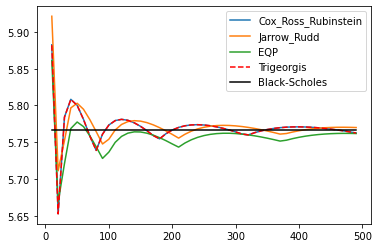

In [17]:
from py_vollib.black_scholes import black_scholes as bs
import matplotlib.pyplot as plt
## call option with different steps 
CRR, JR, EQP, TRG = [],[],[],[]
periods = range(10,500,10)
for N in periods:
    CRR.append(CRR_method(K,T,S0,r,N,sigma,opttype='C'))
    JR.append(JR_method(K,T,S0,r,N,sigma,opttype='C'))
    EQP.append(EQP_method(K,T,S0,r,N,sigma,opttype='C'))
    TRG.append(TRG_method(K,T,S0,r,N,sigma,opttype='C'))
    
BS = [bs('c', S0, K, T, r, sigma) for i in periods]
plt.plot(periods, CRR, label='Cox_Ross_Rubinstein')
plt.plot(periods, JR, label='Jarrow_Rudd')
plt.plot(periods, EQP, label='EQP')
plt.plot(periods, TRG, 'r--',label='Trigeorgis')
plt.plot(periods, BS, 'k',label='Black-Scholes')
plt.legend(loc='upper right')
plt.show()